# NYU RA Screening Task - Xiaoyu Ouyang

In [677]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 1000

# Data Universe

In [536]:
# Pull the datasets
dfA = pd.read_csv("DatasetA.csv")
dfB = pd.read_csv("DatasetB.csv")
dfvar = pd.read_excel("variable definitions.xlsx", engine = "openpyxl")

# Task 1

### Extract "bonus" variable

In [557]:
def find_bonus(df):
    """
    find the bonus information from "Incentive Text" column, extract the bonus amount in $, and return the dataframe with this additional column "bonus"
    create a column "condition" which removes text of bonus for further processing
    """
    
    # step 1: find bonus in the first part of sentence before certain keywords like when, for, after
    # step 2: directly find the first number with dollar sign if not found in step 1
    # step 3: process with bonus in units of cents rather than dollars
    
    pat1 = r"(\$\d+(,\d+)*\b)(?=.*(when|for|after|with|while|on|by))"
    pat2 = r"(\$\d+(,\d+)*\b)"
    pat3 = r"(\d+(,\d+)*\b)(?=.*(cents|cent|Cents))"
    df["bonus"] = np.nan
    df["condition"] = np.nan
    
    for i in range(df.shape[0]):
        text = df.loc[i,"Incentive Text"]
        try:
            match_res = re.search(pat1, text).group()
            df.loc[i, "condition"] = text.replace(match_res,"")
            bonus_num = match_res.replace(",", "").replace("$","")
            df.loc[i,"bonus"] = int(bonus_num)
        except: pass
        
        try:
            match_res = re.search(pat2, text).group()
            df.loc[i, "condition"] = text.replace(match_res,"")
            bonus_num = match_res.replace(",", "").replace("$","")
            df.loc[i,"bonus"] = int(bonus_num)
        except: pass
        
        try:
            match_res = re.search(pat3, text).group()
            df.loc[i, "condition"] = text.replace(match_res,"")
            bonus_num = match_res.replace(",", "").replace("$","")
            df.loc[i,"bonus"] = int(bonus_num)/100
        except:pass
                    
    return df

In [558]:
df_bonus = find_bonus(dfA)
df_left = df_bonus[df_bonus["bonus"].isna()]

In [559]:
df_left[["Incentive Text"]]

,Incentive Text
195,"Up to 4,000 cash bonus when opening a new Citi Savings Account by 09/30/2020 and fund the new eligible savings account with a minimum required deposit in new-to-Citibank funds within the first 30 days of opening the account and maintain the minimum balance in the Citi Savings Account for 90 consecutive days"
3329,"Earn a Premier Checking Account or upgrade the existing checking account to a Premier Checking Account by December 19, 2014"
3868,Get 10 cash back on all debit card purchases
3872,10¢ cash back on every debit card purchases
4006,25 when bringing in the unused checks and debit cards from the current account at another financial institution when opening any new account
4180,100 reward just making 3 debit card purchases within 60 days of opening of the new account
5843,Get free checks when opening a checking account
5918,Polar Peak Cooler free when opening a new Free Checking Account
6337,"Earn 50 bonus deposit when opening a checking account with e-Statements, debit MasterCard and either direct deposit of 5 debit card purchases by June 28, 2013"
8245,"Open a checking account with direct deposit by September 30, 2012 and make a donation to one of three local non-profit organizations"


These 14 rows of "Incentive Text" contain ambiguous information about bonus including unstated units (dollar/cents) and are excluded from future use in this analysis.

In [540]:
df_bonus = df_bonus.drop(df_left.index).reset_index()

### Extract "deposit" variable

In [541]:
def find_deposit(df):
    """
    find the deposit information from "condition" column, extract the deposit amount in $, and return the dataframe with this additional column "bonus"
    create a column "condition" which removes text of bonus for further processing
    """
    # column "condition" does not include bonus data so we look for deposit number starting with dollar sign in the rest of sentence
    pat1 = r"(\$\d+(,\d+)*\b)"
    
    # if no required deposit, we set deposit amount to be zero by default
    df["deposit"] = 0
    
    for i in range(df.shape[0]):
        text = df.loc[i,"condition"]
        
        try:
            match_res = re.search(pat1, text).group()
            deposit_num = match_res.replace(",", "").replace("$","")
            df.loc[i,"deposit"] = int(deposit_num)
        except: pass
    return df

df_deposit = find_deposit(df_bonus)

In [542]:
# Check that the number of rows including "deposit" word is not far from the number of rows with non-zero deposit
check_deposit = lambda x: "deposit" in x
rows_with_word_deposit = df_bonus[df_bonus["Incentive Text"].apply(check_deposit)].shape[0]
rows_with_nonzero_deposit = df_deposit[df_deposit["deposit"] != 0].shape[0]
print("There are "+str(rows_with_word_deposit)+" rows that include the word deposit and " + str(rows_with_nonzero_deposit) + " rows that have specific deposit requirements.")

There are 5859 rows that include the word deposit and 4757 rows that have specific deposit requirements.


In [543]:
# New dataset A including columns bonus and deposit
newA = df_deposit.drop(columns = ["condition","index"])  # 11168 rows
newA.head()

,Primary Company,Campaign ID,Category,Incentive Text,Earliest Month,Latest Month,Observation ID,bonus,deposit
0,Ent Credit Union,20200404-0111266,Checking,"$300 bonus when opening a new checking account with a $100 deposit, activate the debit card and set up a direct deposit",2020-03,2020-03,3,300.0,100
1,Ent Credit Union,20200404-0111266,Checking,"$200 bonus when opening a new checking account and deposit a minimum of $10,000 within 90 days of becoming a member and then maintain funds for 90 days",2020-03,2020-03,5,200.0,10000
2,Ent Credit Union,20201215-011846,Checking,"$100 when referring a friend or family member to open a checking account by February 1, 2021",2020-11,2021-02,9,100.0,0
3,Ent Credit Union,20211231-0111053,Checking,$200 bonus when opening a New Checking Account,2021-12,2021-12,21,200.0,0
4,Ent Credit Union,20221008-0111195,Checking,"$200 bonus when opening an account with promo code, depositing $100 into the new checking account and activating the debit card",2022-09,2022-09,23,200.0,100


# Task 2

In [727]:
# Change bank names to lower case
lowercase = lambda x: x.lower()
bankA = newA["Primary Company"].apply(lowercase).unique() # 1023
bankB = dfB["fullname"].apply(lowercase).unique()
same = list(set(bankA)&set(bankB_full))

# Match rest of bank names except 316 exact matches
bankA_left = [x for x in bankA if x not in same]
bankB_left = [x for x in bankB if x not in same]

# Delet a wrong bank name "bank" in bankB_left
bankB_left.remove("bank")

In [396]:
df_convert = pd.DataFrame()
df_convert["bankA"] = bankA_left
df_convert["convert"] = np.nan
df_convert["score"] = np.nan
convert_dict = dict()

for i in range(len(bankA_left)):
    query = bankA_left[i]
    choices = bankB_left
    match, score = process.extractOne(query, choices)
    df_convert.loc[i,"convert"] = match
    df_convert.loc[i,"score"] = score

In [561]:
# df_convert.to_pickle("df_convert.pkl")  
df_convert = pd.read_pickle("df_convert.pkl")
df_convert

,index,bankA,convert,score,convert_above_threshold
0,1,onewest bank,onewest bank fsb,95.0,onewest bank fsb
1,3,bb&t,bb&t bankcard corp,90.0,bb&t bankcard corp
2,4,suntrust,suntrust bank south central tn n,90.0,suntrust bank south central tn n
3,5,santander,santander bank national association,90.0,santander bank national association
4,11,discover,discover bank,90.0,discover bank
...,...,...,...,...,...
178,693,waycross bank & trust,waycross bank and trust company,95.0,waycross bank and trust company
179,694,sbt advantage bank,1st advantage bank,94.0,1st advantage bank
180,695,belgrade state bank,belgrade st bank,91.0,belgrade st bank
181,697,rollstone bank & trust,stone bank,90.0,stone bank


Text(0.5, 1.0, 'Number of Matches in Bank Names versus Score Threshold')

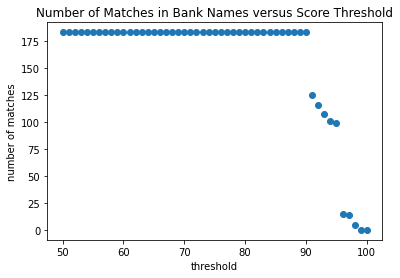

In [562]:
# Return number of matches for a specific score threshold
def num_match(score):
    num_match = len([x for x in df_convert["score"] if x>=score])
    return num_match

# Set an appropriate threshold to score, try score from 70 to 100
score_range = range(50,101)
match_count = [num_match(score) for score in score_range]

# Plot a graph of number of matches in bank names versus score threshold
plt.scatter(score_range, match_count)
plt.xlabel("threshold")
plt.ylabel("number of matches")
plt.title("Number of Matches in Bank Names versus Score Threshold")

From the graph above, it is easily observed that there is a massive drawdown in number of matches when the threshold increases from 85 to 86 and 89 to 90 and 95 to 96. To balance between the number of matches and matching precision, I manually checked the matches and chose the threshold to be 90 which corresponds to 335 additional matches.

In [563]:
# Set the threshold to be 90
df_convert["convert_above_threshold"] = np.nan
df_convert["convert_above_threshold"][df_convert["score"]>=90] = df_convert["convert"][df_convert["score"]>=90]
df_convert = df_convert.dropna()

# Need to check that the mapping is 1-1
# if multiple bank names in data A are matched to the same bank name in data B, only set the one with the highest score with the match
repeated_names = list(set([x for x in list(df_convert["convert_above_threshold"]) if list(df_convert["convert_above_threshold"]).count(x) > 1])) # 22 repeated names
for name in repeated_names:
    temp_df = df_convert[df_convert["convert_above_threshold"]==name]
    index = temp_df["score"].idxmax()
    df_convert["convert_above_threshold"][df_convert["convert_above_threshold"]==name] = np.nan
    df_convert.loc[i, "convert_above_threshold"] = name
df_convert = df_convert.dropna().reset_index(drop=True).drop(columns=["index"]) # match additional 183 names
df_convert.head(10)

,bankA,convert,score,convert_above_threshold
0,onewest bank,onewest bank fsb,95.0,onewest bank fsb
1,bb&t,bb&t bankcard corp,90.0,bb&t bankcard corp
2,suntrust,suntrust bank south central tn n,90.0,suntrust bank south central tn n
3,santander,santander bank national association,90.0,santander bank national association
4,discover,discover bank,90.0,discover bank
5,fifth district savings bank,fifth dist savings bank,92.0,fifth dist savings bank
6,"mufg union bank, n.a.",ion bank,90.0,ion bank
7,usaa,usaa fsb,90.0,usaa fsb
8,tbk bank,tbk bank ssb,90.0,tbk bank ssb
9,new mexico bank & trust,new mexico bank and trust company,95.0,new mexico bank and trust company


In [564]:
# Construct a dictionary to map bank names in dataset A to bank names in dataset B
convert_dict = dict()
for i in range(df_convert.shape[0]):
    convert_dict[df_convert.loc[i,"bankA"]] = df_convert.loc[i,"convert_above_threshold"]
    
for j in range(len(same)):
    convert_dict[same[j]] = same[j]
    
# In total 499 unique bank names in dataset A are matched
def convertAtoB(x):
    x = x.lower()
    try:
        return convert_dict[x]
    except:
        return np.nan

A_name = newA.copy()
A_name["fullname"] = A_name["Primary Company"].apply(convertAtoB)
A_name = A_name.dropna().reset_index()

In [565]:
# Assign dateq (year and quarter) to each record based on 'Campaign ID' field
A_name['dateq'] = np.nan
for i in range(A_name.shape[0]):
    camp = A_name.loc[i,'Campaign ID']
    month = int(np.ceil(int(camp[4:6]) / 3))
    A_name.loc[i,'dateq'] = camp[0:4] + 'q' + str(month)

dfB["fullname"] = dfB["fullname"].apply(lowercase)
dfB_merge = dfB.copy()
dfB_merge.drop_duplicates(subset = ['fullname','dateq'], keep = 'first', inplace = True) 

# Merge two dataframes according to company names and dates
df_merged = pd.merge(left=A_name, right=dfB_merge, left_on=["fullname","dateq"], right_on=["fullname","dateq"], validate="m:1").reset_index()
df_merged.head() # 5549 rows

,level_0,index,Primary Company,Campaign ID,Category,Incentive Text,Earliest Month,Latest Month,Observation ID,bonus,...,timedep,timedepuninsured,unusedcomm,intexp,netinc,intincnet,nonintexp,nonintinc,operinc,domdepservicecharges
0,0,9,Bank of America,20191011-0111226,Savings,"Up to $500 bonus when opening a new savings account and make qualifying direct deposits of $10,000 or more in new money directly into the eligible savings accounts and maintain the qualifying deposits in the eligible savings account for 90 days following the enrollment",2019-10,2019-10,94,500.0,...,61530000.0,28072000.0,NaN,2064000.0,6292000.0,12307000.0,9210000.0,3849000.0,18220000.0,1390000.0
1,1,13,Bank of America,20191031-0111262,Checking,"$300 when opening a new eligible Bank of America personal checking account and set up and receive qualifying direct deposits totaling of $4,000 or more within 90 days of account opening through December 31, 2019",2019-10,2019-11,710,300.0,...,61530000.0,28072000.0,NaN,2064000.0,6292000.0,12307000.0,9210000.0,3849000.0,18220000.0,1390000.0
2,2,14,Bank of America,20191101-0111234,Checking,$350 bonus offer when opening a checking account,2019-10,2020-01,876,350.0,...,61530000.0,28072000.0,NaN,2064000.0,6292000.0,12307000.0,9210000.0,3849000.0,18220000.0,1390000.0
3,3,15,Bank of America,20191018-0117,Checking,"$300 bonus when opening a new Bank of America Advantage Banking account by December 31, 2019 and set up and receive qualifying direct deposits totaling $4,000 or more within 90 days of opening the new account",2019-10,2019-12,940,300.0,...,61530000.0,28072000.0,NaN,2064000.0,6292000.0,12307000.0,9210000.0,3849000.0,18220000.0,1390000.0
4,4,17,Bank of America,20191102-011829,Checking,"$300 when opening a checking account and set up and receive qualifying direct deposit equaling a total of $4,000 or more within 90 days of account opening through December 31, 2019",2019-10,2019-10,1232,300.0,...,61530000.0,28072000.0,NaN,2064000.0,6292000.0,12307000.0,9210000.0,3849000.0,18220000.0,1390000.0


# Task 3

To explore what factors drive banks to use incentive offers, I use the "bonus" and "deposit" columns as response variables and select appropriate variables among other columns in merged dataframe. After checking the non-multicollinearity of variables, I perform linear regressions to identify the statistical significance and effects of explanatory variables to response variables. 

In [654]:
# Prepare the dataframe for performing factor analysis
df_factor = df_merged.copy()
factors = ["assets",
           "reloans",
           "cash",
           "persloans",
           "equity",
           "demanddep",
           "brokereddep",
           "ciloans",
           "loans",
           "liabilities",
           "deposits",
           "timesavdep",
           "timedep",
           "timedepuninsured",
           "unusedcomm",
           "operinc",
           "intexp",
           "intincnet",
           "nonintinc",
           "domdepservicecharges",
           "nonintexp",
           "netinc",
           "nbranch"]

# Distribute datasets into two components X and y where X include all possible explanatory variables and y is the response variable "bonus"
X = df_factor[factors].dropna(axis=1)

### Solve multicollinearity problems in explanatory variables

<AxesSubplot:>

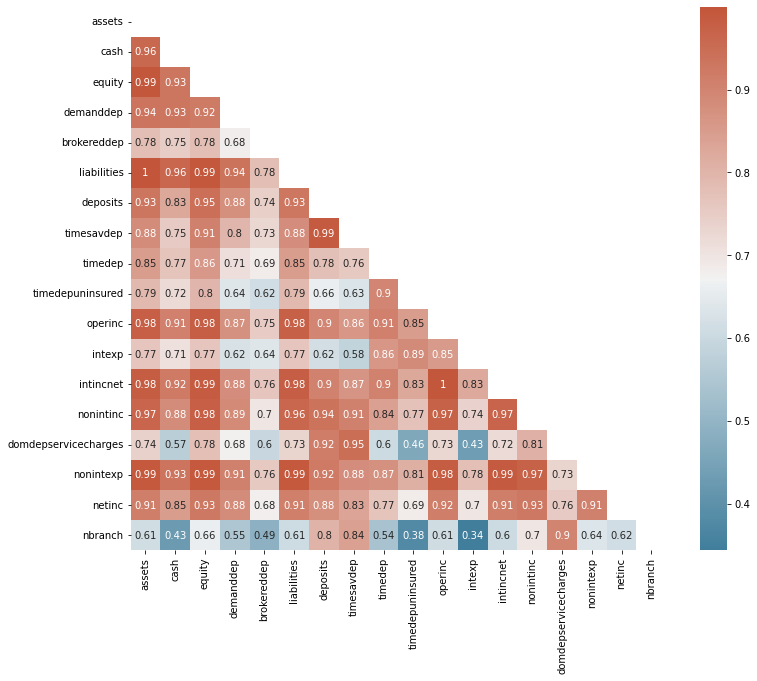

In [655]:
# Plot a correlation matrix heatmap to see if certain explanatory variables are highly correlated
corr = X.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

From the correlation heatmap, it is easily observed that almost all correlation coefficients are above 0.5, suggesting multicollinearities exist among variables. Therefore, I calcualte Variance Inflation Factor (VIF) below and remove variables with high VIF values.

In [656]:
# Calculate Variance Inflation Factor
def VIF(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info = vif_info.sort_values('VIF', ascending=False)
    return vif_info
VIF1 = VIF(X).reset_index().drop(columns=["index"])
VIF1

,VIF,Column
0,inf,demanddep
1,inf,deposits
2,inf,timesavdep
3,inf,operinc
4,inf,intexp
5,inf,intincnet
6,inf,nonintinc
7,2.781102e+07,assets
8,2.243355e+07,liabilities
9,2.969265e+05,equity


From the table above, almost all variables have a VIF value above 5, thus we need to remove multicollinearities. First, I will remove some variables which are highly correlated from their definitions. For example, net income = net interest income+non interest income, so for simplicity I only keep netinc. And I will only keep the ones with VIF not equal to inf. Then I rerun the VIF with selected explanatory variables.

In [666]:
selected_factors = list(VIF1.loc[11:,"Column"])
X = df_factor[selected_factors].dropna(axis=1)
VIF(X)

,VIF,Column
2,9.113261,timedep
1,8.733078,domdepservicecharges
5,6.955179,netinc
4,6.571823,nbranch
3,6.222759,timedepuninsured
0,5.868815,cash
6,2.982250,brokereddep


Here we only choose the variables with VIF lower than 10 to avoid the problem of multicollinearity in the regression analysis.

### Regression Analysis -- Bonus

In [724]:
X = sm.add_constant(X)
y = np.asarray(df["bonus"])
model_result = sm.OLS(y, X).fit()
model_result.summary(title="OLS Regression Results of Bonus against Explanatory Variables")

<class 'statsmodels.iolib.summary.Summary'>
"""
        OLS Regression Results of Bonus against Explanatory Variables         
==============================================================================
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          9.93e-258
Time:                        22:23:44   Log-Likelihood:                -38710.
No. Observations:                5549   AIC:                         7.744e+04
Df Residuals:                    5541   BIC:                         7.749e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  148.3235      4.176     35.521      0.000     140.138     156.510
cash                  2.547e-06   1.26e-07     20.212      0.000     2.3e-06    2.79e-06
domdepservicecharges    -0.0005    5.8e-05     -8.103      0.000      -0.001      -0.000
timedep               -4.05e-08   6.54e-07     -0.062      0.951   -1.32e-06    1.24e-06
timedepuninsured      2.165e-07   9.54e-07      0.227      0.820   -1.65e-06    2.09e-06
nbranch                  0.1121      0.012      9.012      0.000       0.088       0.136
netinc               -2.896e-05   7.31e-06     -3.965      0.000   -4.33e-05   -1.46e-05
brokereddep           9.302e-08   2.32e-07      0.401      0.689   -3.62e-07    5.48e-07
==============================================================================
Omnibus:                     7474.042   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2432171.352
Skew:                           7.533   Prob(JB):                         0.00
Kurtosis:                     104.451   Cond. No.                     8.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This regression results table generally indicates that bonus can be modeled as a linear combination of some variables above.

- R_squared = 0.197 shows that 19.7% of the change in ‘bonus’ variable can be explained by these variables and this linear model is a good fit to data.
- P>|t| is the p-value and the statistically significant variables (p<0.1) include "cash","domdepservicecharges","nbranch", "netinc".
- When there is more cash, lower service charges on domestic deposits, more number of branches, and lower net income for the bank, the bank is likely to require higher bonus.

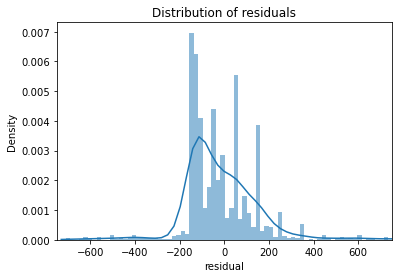

In [725]:
# plot the histogram of residuals
fig, ax = plt.subplots()
sns.histplot(x=model_result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")
ax.set_xlim([-750,750])
fig.show()

The distribution of residuals is quite balanced below and above zero, the fitted density distribution line has a bell shape similar to that of a normal distribution.

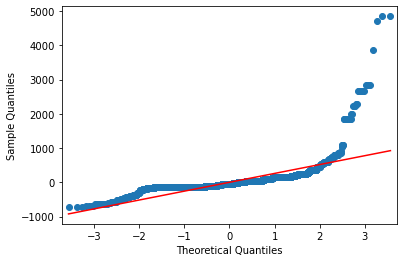

In [726]:
# Q-Q plot of residuals in linear regression
sm.qqplot(model_result.resid, line='s')
ax.set(title="Q-Q Plot of Residuals in Linear Regression", xlabel="residual")
plt.show()

From the Q-Q plot, most of the points are close to the fitted red line except a few outliers (the proportion of number of outliers is very small), which suggests the residuals generally follow a normal distribution. These two plots together further prove that this linear model is a good fit to the data.

### Regression Analysis -- Deposit

In [719]:
X = sm.add_constant(X)
y = np.asarray(df["deposit"])
model_result = sm.OLS(y, X).fit()
model_result.summary(title="OLS Regression Results of Deposit against Explanatory Variables")

<class 'statsmodels.iolib.summary.Summary'>
"""
        OLS Regression Results of Bonus against Explanatory Variables         
==============================================================================
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     176.4
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          1.61e-236
Time:                        22:22:39   Log-Likelihood:                -67720.
No. Observations:                5549   AIC:                         1.355e+05
Df Residuals:                    5541   BIC:                         1.355e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3589.0508    778.458      4.610      0.000    2062.967    5115.134
cash                     0.0004   2.35e-05     17.716      0.000       0.000       0.000
domdepservicecharges    -0.0577      0.011     -5.328      0.000      -0.079      -0.036
timedep                  0.0002      0.000      1.697      0.090   -3.22e-05       0.000
timedepuninsured        -0.0014      0.000     -7.942      0.000      -0.002      -0.001
nbranch                 -1.9717      2.319     -0.850      0.395      -6.518       2.574
netinc                   0.0051      0.001      3.725      0.000       0.002       0.008
brokereddep           9.111e-05   4.33e-05      2.106      0.035    6.28e-06       0.000
==============================================================================
Omnibus:                     9862.357   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11086378.787
Skew:                          12.777   Prob(JB):                         0.00
Kurtosis:                     220.478   Cond. No.                     8.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This regression results table generally indicates that deposit can be modeled as a linear combination of some variables above.

- R_squared = 0.182 shows that 18.2% of the change in ‘deposit’ variable can be explained by these variables and this linear model is a good fit to data.
- P>|t| is the p-value and the statistically significant variables (p<0.1) include "cash","domdepservicecharges","timedepuninsured", "netinc".
- When there is more cash, lower service charges on domestic deposits, lower uninsured time deposits, and more net income for the bank, the bank is likely to require higher deposit.

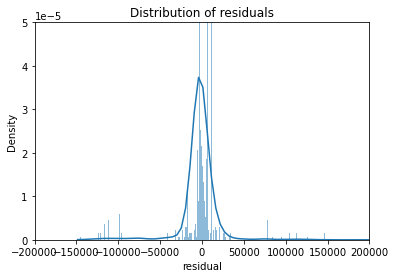

In [720]:
# Histogram of residuals
fig, ax = plt.subplots()
sns.histplot(x=model_result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")
ax.set_ylim([0, 0.00005])
ax.set_xlim([-200000, 200000])
fig.show()

From this histogram, it can be easily observed that the distribution of residuals has a density plot very similar to that of the normal distribution.

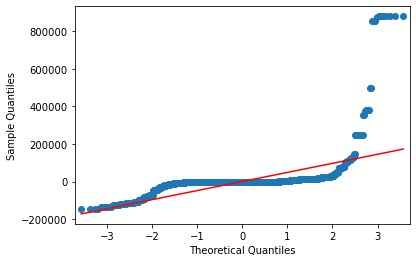

In [723]:
# Q-Q plot of residuals in linear regression
sm.qqplot(model_result.resid, line='s')
plt.show()

Similar to above, most of the points are close to the fitted red line except a few outliers (the proportion of number of outliers is very small), which suggeststhat  this linear model is a good fit to the data.

In [734]:
y1 = np.asarray(df["bonus"])
y2 = y = np.asarray(df["deposit"])
corr = np.corrcoef(y1,y2)
print("The correlation coefficient between bonus and deposit is " +str(corr[0][1]))

The correlation coefficient between bonus and deposit is 0.6304477187889876
